In [7]:
%load_ext jupyternotify
%load_ext autoreload
%autoreload 2

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import functools
import jax
import os
import pandas as pd
import mlflow
import pickle
import spot

from datetime import datetime
from jax import numpy as jnp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output
import mediapy

import brax

import flax

# tasks
from task_aware_skill_composition.brax.tasks import get_task
from task_aware_skill_composition.brax.cmdp import make_cmdp
from task_aware_skill_composition.brax.reward_shaping import (
    make_shaped_reward_mdp,
    make_shaped_reward_mdp2,
    make_aut_goal_mdp
)

mlflow.set_tracking_uri(f"file:///home/tassos/.local/share/mlflow")

# Defining STL

In [9]:
import corallab_stl.expression_jax2 as stl

# Defining Env/Task

In [10]:
mlflow.set_experiment("proj2-hierarchy-comparison")

<Experiment: artifact_location='file:///home/tassos/.local/share/mlflow/778019973331947620', creation_time=1731686379807, experiment_id='778019973331947620', last_update_time=1731686379807, lifecycle_stage='active', name='proj2-hierarchy-comparison', tags={}>

In [144]:
backend = 'mjx'

task = get_task("simple_maze", "obligation1")
env = task.env

spec = task.lo_spec
spec_tag = type(task).__name__
env_tag = type(env).__name__

jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

In [145]:
print(spec_tag)
print(spec)
print(env.observation_size)
print(env.action_size)
alg_suffix = ""

SimpleMazeObligationConstraint1
6
2


## Making the Env Automaton Wrapped

In [170]:
from task_aware_skill_composition.brax.envs.wrappers.automaton_wrapper import AutomatonWrapper
from task_aware_skill_composition.brax.envs.wrappers.automaton_transition_rewards_wrapper import AutomatonTransitionRewardsWrapper
from task_aware_skill_composition.brax.envs.wrappers.automaton_cost_wrapper import AutomatonCostWrapper

cmdp = make_cmdp(task)
aut = cmdp.automaton.automaton
formula = cmdp.automaton.formula
canon_aut = spot.scc_filter_states(aut)

# Safety

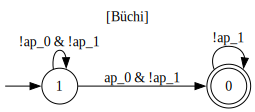

In [184]:
safety_aut = spot.make_twa_graph(canon_aut, spot.twa_prop_set.all(), True)
safety_aut

In [185]:
m = safety_aut.set_buchi()


In [190]:
for edge in safety_aut.edges():
    edge.acc = m

0 goes to 0 when !ap_1
1 goes to 0 when ap_0 & !ap_1
1 goes to 1 when !ap_0 & !ap_1


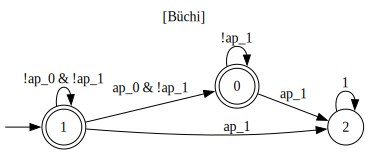

In [193]:
bdd_dict = safety_aut.get_dict()
q_trap = safety_aut.new_state()

for state in range(safety_aut.num_states()):
    fs = []

    for edge in safety_aut.out(state):
        f_i = spot.bdd_to_formula(edge.cond, bdd_dict)
        fs.append(f_i)
        print(f"{edge.src} goes to {edge.dst} when {f_i}")

    f = spot.formula_Not(spot.formula_Or(fs))
    f_bdd = spot.formula_to_bdd(f, bdd_dict, None)
    safety_aut.new_edge(state, q_trap, f_bdd)

safety_aut

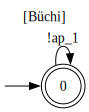

In [195]:
spot.minimize_obligation(safety_aut)

In [182]:
safety_aut.set_acceptance(0, spot.acc_code.t())

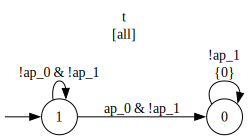

In [183]:
safety_aut

In [179]:
spot.is_safety_automaton(safety_aut)

False

# Liveness

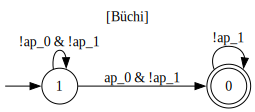

In [175]:
liveness_aut = spot.make_twa_graph(canon_aut, spot.twa_prop_set.all(), True)
liveness_aut

0 goes to 0 when !ap_1
1 goes to 0 when ap_0 & !ap_1
1 goes to 1 when !ap_0 & !ap_1


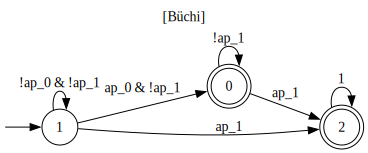

In [176]:
bdd_dict = liveness_aut.get_dict()
q_trap = liveness_aut.new_state()

for state in range(liveness_aut.num_states()):
    fs = []

    for edge in liveness_aut.out(state):
        f_i = spot.bdd_to_formula(edge.cond, bdd_dict)
        fs.append(f_i)
        print(f"{edge.src} goes to {edge.dst} when {f_i}")

    f = spot.formula_Not(spot.formula_Or(fs))
    f_bdd = spot.formula_to_bdd(f, bdd_dict, None)
    liveness_aut.new_acc_edge(state, q_trap, f_bdd)

liveness_aut

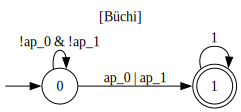

In [196]:
spot.minimize_obligation(liveness_aut)